In [1]:
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
from birdclassification.training.dataset import Recordings30
from birdclassification.training.cnn_training_torch.CNN_model import CNNNetwork
from skimage.color import rgb2gray

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
PATH = ('cnn_1.pt')
cnn = CNNNetwork()
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [3]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 123
#RECORDINGS_DIR = '/mnt/d/recordings_30/'
RECORDINGS_DIR =  '/media/jacek/E753-A120/recordings_30/'
NOISES_DIR = '/path/to/noise/dataset'
SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 5
NUM_WORKERS = 8

/home/jacek/PycharmProjects/Bird-classification-model/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
df = filter_recordings_30("../data/xeno_canto_recordings.csv", "../data/bird-list-extended.csv", )

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state = SEED)

train_ds = Recordings30(train_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=SAMPLE_RATE, device = DEVICE)
val_ds = Recordings30(val_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate = 32000, device = DEVICE)
test_ds = Recordings30(test_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR,sample_rate = 32000,device = DEVICE)

train_dl  = DataLoader(train_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)
val_dl  = DataLoader(val_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)
test_dl  = DataLoader(test_ds, batch_size= BATCH_SIZE, num_workers=NUM_WORKERS)

/home/jacek/PycharmProjects/Bird-classification-model/birdclassification/preprocessing/filtering.py:72: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


In [14]:
from lime import lime_image

spectrogram, label = train_ds[0]

def batch_predict(images):
    cnn.eval()
    batch = torch.stack(tuple(torch.Tensor(rgb2gray(i)) for i in images), dim=0)
    batch = torch.unsqueeze(batch, dim = 0)  
    batch = batch.permute(1, 0, 2, 3)
    logits = cnn(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(spectrogram, 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color= True, 
                                         num_samples=2500,
                                         batch_size = 10
                                         ) # number of images that will be sent to classification function

  0%|          | 0/2500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


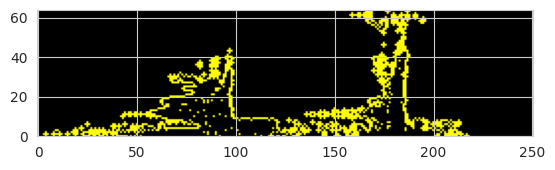

In [15]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.ylim(0, 64)
plt.imshow(img_boundry1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


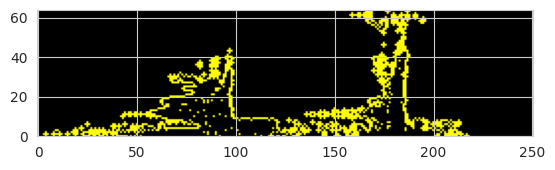

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.ylim(0, 64)
plt.imshow(img_boundry2)

In [17]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
mask.shape

(64, 251)

In [19]:
temp[0,0]

array([-40.95372, -40.95372, -40.95372], dtype=float32)

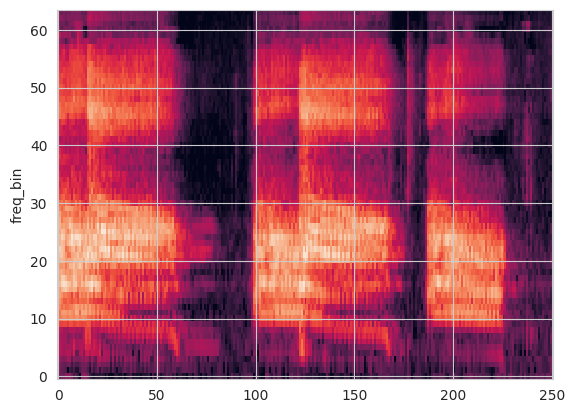

In [20]:
from birdclassification.visualization.plots import plot_torch_spectrogram
plot_torch_spectrogram(spectrogram)

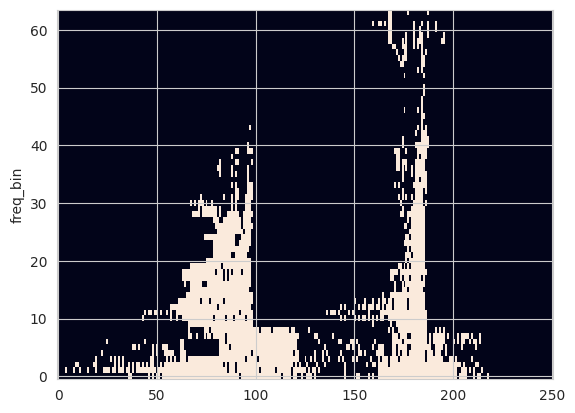

In [21]:
plot_torch_spectrogram(torch.Tensor(mask))